# overview of campaign deployments

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
campaign="taos0_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque


In [11]:
dr = cp.load('drifters.nc', toframe=True)

ship = dict(ship_hydrophone=cp.load('ship_hydrophone', toframe=True),
            ship_parceque=cp.load('ship_parceque', toframe=True),
           )
#ctd = dict(ctd_hydrophone=cp.load('ctd_hydrophone'),
#           ctd_parceque=cp.load('ctd_parceque'),
#          )

wind = cp.load("arome.nc")
slvl = cp.load('sea_level.nc', toframe=True)

dr.head()

,time,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,x,y,ux,uy,velocity,deployment
id,,,,,,,,,,,,
0-4351896,2022-05-17 09:40:00,0.0,0.0,3.0,49.339996,-0.245942,486.942445,-277.990901,0.245940,-0.143176,0.284581,d0
0-4351896,2022-05-17 10:00:00,0.0,0.0,3.0,49.338449,-0.242536,734.523943,-450.070782,0.206318,-0.143400,0.251258,d0
0-4351896,2022-05-17 10:20:00,0.0,0.0,3.0,49.337113,-0.239821,931.824526,-598.570348,0.164417,-0.123750,0.205784,d0
0-4351896,2022-05-17 10:40:00,0.0,0.0,3.0,49.335820,-0.238266,1044.900275,-742.352760,0.094230,-0.119819,0.152433,d0
0-4351896,2022-05-17 11:00:00,0.0,0.0,3.0,49.334592,-0.238062,1059.752887,-879.006872,0.012377,-0.113878,0.114549,d0


---
### time line

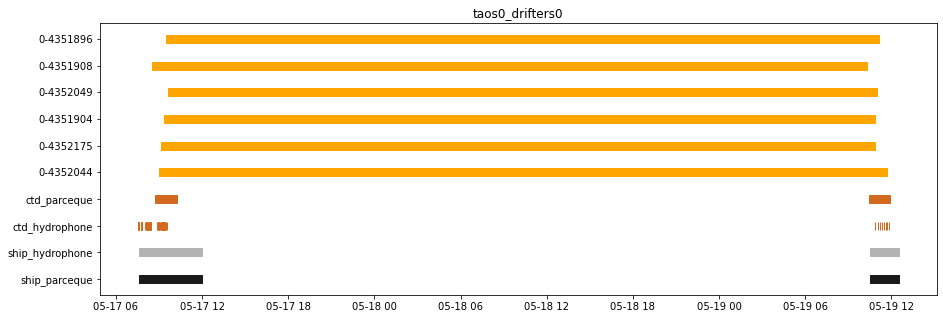

In [4]:
cp.timeline(legend=None)

### Plot overview of both campaigns along with sea level and wind

Text(0, 0.5, '[m/s]')

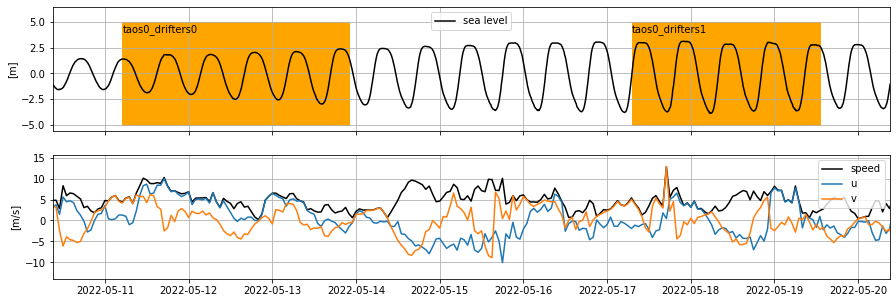

In [56]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(2,1, figsize=(15,5))

height=10
y=0
starts, ends = [], []

ax = axes[0]

for cpg in ["taos0_drifters0", "taos0_drifters1"]:
    yaml = cpg.split("_")[-1] + f"/{cpg}.yaml"
    _cp = pin.campaign(os.path.join(root_dir,yaml), verbose=False)
    #print(_cp)

    start = mdates.date2num(_cp.start)
    end = mdates.date2num(_cp.end)
    rect = Rectangle((start, y-height/2.), end-start, height,
                     color="orange")
    ax.add_patch(rect)
    starts.append(start)
    ends.append(end)
    #print(start, end-start)
    ax.text(start, y+height*0.4, cpg)

# sea level
_mtime = slvl.index.map(lambda t: mdates.date2num(t))
_slvl = slvl.sea_level.values
ax.plot(_mtime, _slvl, color="k", label="sea level")
    
delta_time = max(ends) - min(starts)

def _set_axis(ax, xticklabels=True):

    ax.set_xlim(min(starts)-0.1*delta_time, max(ends)+0.1*delta_time)
    locator = mdates.AutoDateLocator(minticks=3)
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    if not xticklabels:
        ax.set_xticklabels([])
    ax.grid()
    ax.legend()

_set_axis(ax, xticklabels=False,)
ax.set_ylabel("[m]")

### 
ax = axes[1]
    
# wind
_mtime = mdates.date2num(wind.time)
lon, lat = cp["0-4351908"]["d0"].start.lon, cp["0-4351908"]["d0"].start.lat
_w = wind.sel(longitude=lon, latitude=lat, method="nearest")
_uv10 = np.sqrt(_w.u10m**2+_w.v10m**2)
ax.plot(_mtime, _uv10, color="k", label="speed")
ax.plot(_mtime, _w.u10m, label="u")
ax.plot(_mtime, _w.v10m, label="v")

ax.legend()

_set_axis(ax)
ax.set_ylabel("[m/s]")


---

### maps

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


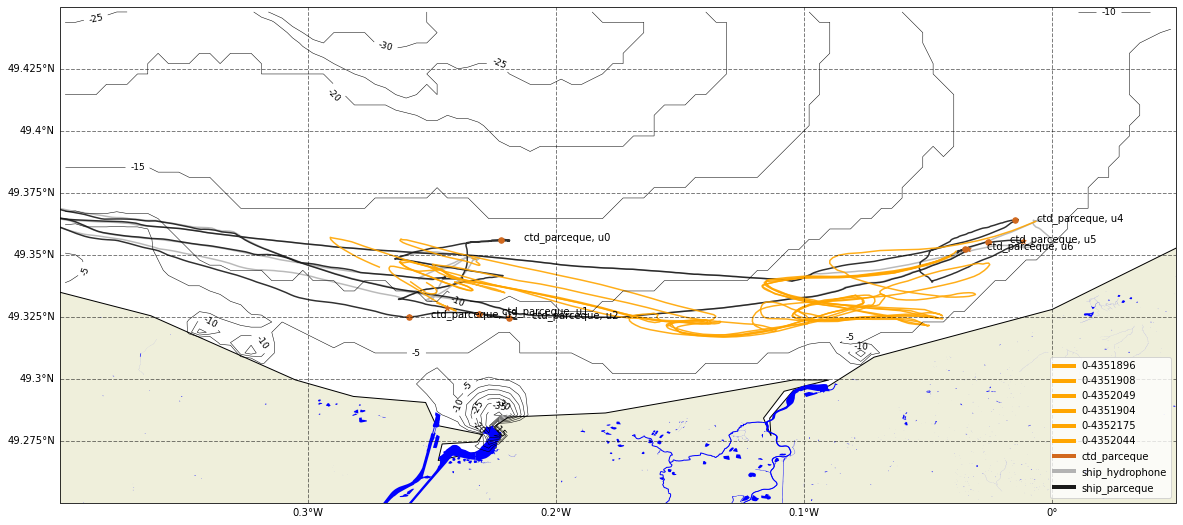

In [5]:


fig, ax, crs = cp.plot_map(coast="bseine", land=None, rivers="bseine", figsize=(20,10))

for uname, unit in cp.items():
    if "ship" in uname:
        s = ship[uname]
        for d, df in s.items():
            ax.plot(df.longitude, df.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=0)
        continue
    if "ctd" in uname and False:
        c = ctd[uname]
        for d, df in c.items():
            ax.plot(df.longitude, df.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=1)
        continue
    if "0-4" in uname:
        _df = dr.loc[uname]
        for d in _df["deployment"].unique():
            _dfd = _df.loc[_df.deployment==d].sort_values("time").set_index("time")
            ax.plot(_dfd.longitude, _dfd.latitude, color=cp[uname]["color"], alpha=0.9,
                    transform=crs, label=uname+", "+d, zorder=1)
        continue
            
    for d in unit:
        line=False
        yshift=0.
        label=uname+', '+d.label
        #if unit=='ctd':
        #    line=False
        #else:
        #    line=True
        #if unit=='source':
        #    yshift=2
        #else:
        #    yshift=0.
        d.plot_on_map(ax, line=line, label=label, color=unit['color'], yshift=yshift)

cp.add_legend(ax, loc=4)

In [6]:
# store bathymetric contours prior to folium plots
if False:
    pin.store_bathy_contours(cp.bathy["label"], 
                             os.path.join(cp.pathp, 'bathy_contours.geojson'),
                             levels=cp.bathy["levels"],
                            )

In [7]:
#cp.map(overwrite_contours=True)
cp.map(zoom=11, ignore=["ship_hydrophone", "ship_parceque"])

### surface drifters

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


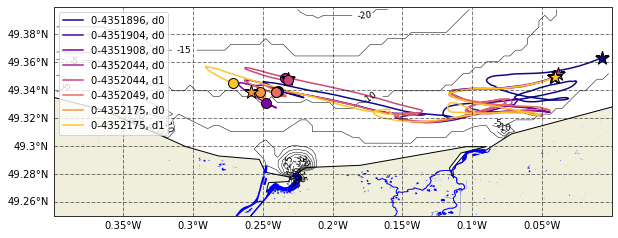

In [6]:

#bounds=[-.5, -.1, 49.25, 49.5]
if campaign=="taos0_drifters0":
    bounds=[-.4, .0, 49.25, 49.4] # taos0-drifters0
elif campaign=="taos0_drifters1":
    bounds=[-.45, -.15, 49.25, 49.45] # taos0-drifters1

_df = dr.reset_index().set_index(["id", "deployment"])
    
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index().dropna(axis=1)
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))
    ax.scatter(_dfk.longitude.iloc[0], _dfk.latitude.iloc[0], color=c, transform=crs,
            edgecolor="k", s=100, zorder=10, marker="o",
           )
    ax.scatter(_dfk.longitude.iloc[-1], _dfk.latitude.iloc[-1], color=c, transform=crs,
            edgecolor="k", s=200, zorder=10, marker="*",
           )

ax.legend()

---

## movie


In [9]:

def make_movie(cp, tstart, tend,
               drifters=None,
               ship=None,
               wind=None,
               ctd=None,
               bounds=None,
               istart=None,
              ):
    """ Make a movie
    """
    
    from tqdm import tqdm
    
    t_range = pd.date_range(tstart, tend, freq='10T')
    del_t = pd.Timedelta('1H')

    plt.switch_backend('agg')

    fig_dir = os.path.join(cp.pathp, 'figs/')

    i=-1
    for t in tqdm(t_range):
        i+=1
        
        if i<istart:
            continue

        fig, ax, crs = cp.plot_map(figsize=(10,10), bounds=bounds, 
                                   coast="bseine", land=None, rivers="bseine",
        )

        # ship
        if ship is not None:
            for u, s in ship.items():
                for d, sd in s.items():
                    _s = sd.loc[t-del_t:t]
                    if _s.index.size>0:
                        ax.plot(_s['longitude'], _s['latitude'], lw=2, color='0.5', alpha=.8)
                        
        # wind
        if wind is not None:
            _di = 2
            _ds = (wind.interp(time=t).isel(longitude=slice(0,None,_di),latitude=slice(0,None,_di))
                  )
            q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
            qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                              labelpos='W', coordinates='axes', zorder=10)            
                
        # drifters
        if drifters is not None:
            #ids = dr.index.unique()
            ids = [u for u in cp if  "0-435" in u] # prefered as if leads to correct color ordering in legend
            colors = pin.get_cmap_colors(len(ids))
            for idx, c in zip(ids, colors):
                df = dr.loc[idx]
                for d in df["deployment"].unique():
                    _df = df.loc[df.deployment==d].set_index("time")
                    _df = _df.loc[t-del_t:t]
                    if _df.index.size>0:
                        ax.plot(_df.longitude, _df.latitude, color=c,  #cp[idx]["color"]
                                transform=crs, label=f"{idx}, {d}", lw=2)
                        ax.plot(_df.longitude[-1], _df.latitude[-1], color=c, #cp[idx]["color"]
                                marker="*", markeredgecolor="k", markeredgewidth=.5,
                                transform=crs, label=f"{idx}, {d}", lw=2, markersize=10)

        cp.add_legend(ax, loc=4, colors={idx: c for idx, c in zip(ids, colors)})
        ax.set_title(cp.name+'  '+str(t))

        figname = fig_dir+'fig_t%05d' %(i)+'.png'
        _ = fig.savefig(figname, dpi=150, facecolor='w', bbox_inches = 'tight')
        _ = fig.clf()
        
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [10]:
### taos0 - drifters0
bounds, istart = None, 0
if campaign=="taos0_drifters0":
    tstart = '2022-05-11 05:00:00'
    #tend = '2022-05-11 09:00:00'
    tend = '2022-05-13 10:00:00'
    bounds = [-.3, .05, 49.25, 49.45]
elif campaign=="taos0_drifters1":
    tstart = '2022-05-17 08:00:00'
    #tend = '2022-05-17 09:00:00'
    tend = '2022-05-19 13:30:00'
    #istart = 315
    bounds = [-.45, -.15, 49.25, 49.45]

#make_movie(cp, tstart, tend, drifters=dr, ship=ship, wind=wind, bounds=bounds, istart=istart)

In [7]:
# convert dataframe to xarray indexed by id and time
ds = dr.reset_index().set_index(["id", "time"]).to_xarray()
ds.geo.set_projection_reference((float(ds.longitude.mean()), float(ds.latitude.mean())))

# recompute projection
ds.geo.project(overwrite=True)
# center of gravity
ds["x_center"] = ds.x.mean("id")
ds["y_center"] = ds.y.mean("id")
# relative position
ds["x_prime"] = ds.x - ds.x_center
ds["y_prime"] = ds.y - ds.y_center

### overview plot

0-4351896 0.0
0-4351904 -21.572648477855182
0-4351908 -486.6540430448149
0-4352044 488.653218733195
0-4352049 -18.839504420795492
0-4352175 -844.971742259374


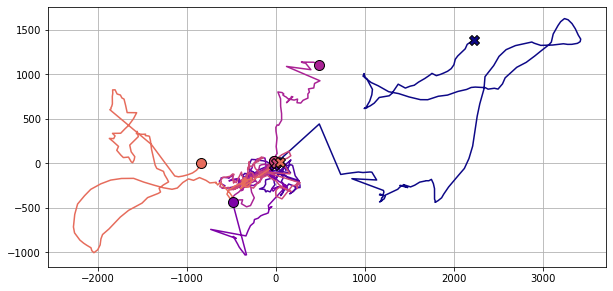

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
#ds.plot.scatter("x_prime", "y_prime", hue="id", s=5)
for i, c in zip(ds.id, colors):
    _ds = ds.sel(id=i).dropna("time")
    ax.plot(_ds.x_prime, _ds.y_prime, color=c)
    print(i.values, float(_ds.x_prime.isel(time=0)))
    ax.scatter(_ds.x_prime.isel(time=0), _ds.y_prime.isel(time=0), s=100, color=c, marker="o", edgecolors="k", zorder=10)
    ax.scatter(_ds.x_prime.isel(time=-1), _ds.y_prime.isel(time=-1), s=100, color=c, marker="X", edgecolors="k", zorder=10)
ax.set_aspect("equal")
ax.grid()

In [13]:
ds["lon_center"], ds["lat_center"] = ds.geo.compute_lonlat(x=ds.x_center, y=ds.y_center)

In [25]:
# interpolate wind along drifter trajectories
interp = lambda d: (wind[d+"10m"]
                    .interp(time=ds.time)
                    .interp(longitude=ds.lon_center, latitude=ds.lat_center)
                    .drop(["longitude", "latitude"])
                   )
ds["u_wind"] = interp("u")
ds["v_wind"] = interp("v")

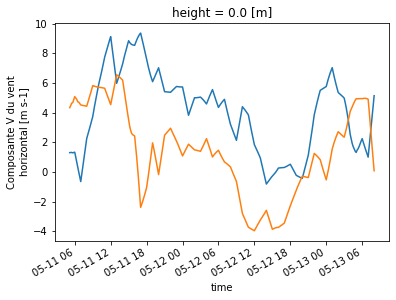

In [28]:
ds.u_wind.plot()
ds.v_wind.plot()

In [29]:
del_t = pd.Timedelta('1H')

In [33]:
ds.sel(time=slice(ds.time[10]-del_t, ds.time[10]))

<xarray.Dataset>
Dimensions:           (id: 6, time: 7)
Coordinates:
  * id                (id) object '0-4351896' '0-4351904' ... '0-4352175'
  * time              (time) datetime64[ns] 2022-05-11T05:50:00 ... 2022-05-1...
    height            float32 0.0
Data variables: (12/19)
    GPS Confidence    (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GPS Fail Counter  (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GpsQuality        (id, time) float64 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    latitude          (id, time) float64 49.34 49.34 49.34 ... 49.34 49.34 49.34
    longitude         (id, time) float64 -0.3195 -0.3175 ... -0.3293 -0.3288
    x                 (id, time) float64 -7.638e+03 -7.491e+03 ... -8.316e+03
    ...                ...
    x_prime           (id, time) float64 582.8 565.3 598.3 ... -612.6 -642.7
    y_prime           (id, time) float64 -28.39 -246.5 -236.6 ... -131.7 -144.9
    lon_center        (time) float64 -0.3275 -0.3253 -0.3239 ... -0.3209 -0.32
    lat_center        (time) float64 49.34 49.34 49.34 49.34 49.34 49.34 49.34
    u_wind            (time) float64 1.319 1.331 0.99 ... -0.003808 -0.3274
    v_wind            (time) float64 4.868 5.083 4.99 4.895 4.734 4.708 4.615

In [40]:

def make_movie(cp,
               drifters=None,
               wind=None,
               istart=0,
              ):
    """ Make a movie
    """
    
    from tqdm import tqdm
    
    plt.switch_backend('agg')
    fig_dir = os.path.join(cp.pathp, 'figs/')
    
    del_t = pd.Timedelta('2H')
    
    dl = 5e3
    xlims = (-dl,dl)
    ylims = (-dl,dl)

    i=-1
    for t in tqdm(drifters.time):
        i+=1
        
        if i<istart:
            continue

        fig, ax = plt.subplots(1,1,figsize=(10,10))
        
        ds = drifters.sel(time=slice(t-del_t, t))
        
        # wind
        if wind is not None:
            _di = 2
            _ds = (wind.interp(time=t).isel(longitude=slice(0,None,_di),latitude=slice(0,None,_di))
                  )
            q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
            qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                              labelpos='W', coordinates='axes', zorder=10)            
                
        # drifters
        #ids = dr.index.unique()
        ids = [u for u in cp if  "0-435" in u] # prefered as if leads to correct color ordering in legend
        colors = pin.get_cmap_colors(len(ids))
        for idx, c in zip(ids, colors):
            _ds = ds.sel(id=idx)
            if _ds.time.size>0:
                ax.plot(_ds.x_prime, _ds.y_prime, color=c, lw=2)
   
        ax.set_xlim(*xlims)
        ax.set_ylim(*ylims)
        ax.set_aspect("equal")
        ax.grid()
        
        cp.add_legend(ax, loc=4, colors={idx: c for idx, c in zip(ids, colors)})
        ax.set_title(cp.name+'  '+str(t.values))

        figname = fig_dir+'fig_t%05d' %(i)+'.png'
        _ = fig.savefig(figname, dpi=150, facecolor='w', bbox_inches = 'tight')
        _ = fig.clf()
        
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
### taos0 - drifters0
bounds, istart = None, 0
if campaign=="taos0_drifters0":
    tstart = '2022-05-11 05:00:00'
    tend = '2022-05-11 09:00:00'
    #tend = '2022-05-13 10:00:00'
elif campaign=="taos0_drifters1":
    tstart = '2022-05-17 08:00:00'
    #tend = '2022-05-17 09:00:00'
    tend = '2022-05-19 13:30:00'
    #istart = 315

make_movie(cp, ds)

---

### folium tests

In [44]:
import folium
from matplotlib.colors import cnames
from folium.plugins import MeasureControl, MousePosition

In [ ]:
folium.GeoJson?

In [ ]:
folium.features.GeoJsonPopup?

In [ ]:
tiles='Stamen Terrain'
tiles='Cartodb Positron'

m = folium.Map(location=[cp.lat_mid, cp.lon_mid],
               width='80%',
               height='80%',
               zoom_start=11,
               tiles=tiles,
               titles='my title', 
               attr="attribution",
              )

contours_geojson = insi.utils.load_bathy_contours()
tooltip = folium.GeoJsonTooltip(fields=['title'], aliases=['depth'], localize=True)
popup = folium.GeoJsonPopup(fields=['title'], aliases=['depth'], localize=False)

#folium.Popup(
def style_func(feature):
    return {'color':   feature['properties']['stroke'], #colorscale(feature['properties']['level-value']),
            'weight':  3, #x['properties']['stroke-width'],
            #'fillColor': x['properties']['fill'],
            'opacity': 1.,
            #'popup': 'depth '+feature['properties']['title'],
           }

folium.GeoJson(
    contours_geojson,
    name='geojson',
    style_function=style_func,
    tooltip=tooltip,
    popup=popup,
).add_to(m)

for uname, u in cp.items():
    for d in u:
        folium.Polygon([(d.start.lat, d.start.lon), (d.end.lat, d.end.lon)],
                       tooltip=uname+' '+d.label+'<br>'+str(d.start.time)+'<br>'+str(d.end.time),
                       color=cnames[u['color']],
                       dash_array='10 20',
                       opacity=.5
                      ).add_to(m)
        folium.Circle((d.start.lat, d.start.lon),
                      tooltip=uname+' '+d.label+'<br>'+str(d.start.time),
                      radius=2*1e2,
                      color=cnames[u['color']],
                     ).add_to(m)
        folium.Circle((d.end.lat, d.end.lon),
                      tooltip=uname+' '+d.label+'<br>'+str(d.end.time),
                      radius=1e2,
                      color=cnames[u['color']],
                     ).add_to(m)

MeasureControl().add_to(m)
MousePosition().add_to(m)

folium.features.DivIcon

m

In [ ]:
folium.plugins.FloatImage?

In [ ]:
folium.features.DivIcon?